# Library Import

We be using some packages to do the analysis and also extract data from nsepy and fundamentalanalysis website. 

In [ ]:
!pip install nsepy --quiet

In [ ]:
!pip install fundamentalanalysis --quiet

In [ ]:
import pandas as pd
from nsepy import get_history
from datetime import date
import fundamentalanalysis as fa

## Key in own API key from from https://site.financialmodelingprep.com/developer/docs/

Thereafter, extract the data and store it in github to avoid having to call APIs repeatedly which is chargeable.

In [ ]:
YOUR_API_KEY = 'key in your own api'

In [ ]:
# get data from our github repo
!git clone https://github.com/emma250/Group_1169_DataSet.git --quiet

In [ ]:
us_df = pd.read_excel('/content/Group_1169_DataSet/Copy of 30 STOCKS.xlsx')
india_df= pd.read_csv('/content/Group_1169_DataSet/mbfm_data - Sheet1.csv')
df_tickers = pd.read_csv('/content/Group_1169_DataSet/ind_nifty50list.csv')

nifty50_tickers = list(df_tickers['Symbol'])
us30_tickers = list(us_df['Ticker'].dropna().unique())

### Utility Function to read data

In [ ]:
#!/usr/bin/env python
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

import certifi
import json

def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

In [ ]:
# url = (f'https://financialmodelingprep.com/api/v3/financial-statement-symbol-lists?apikey={YOUR_API_KEY}')
# stock_list = get_jsonparsed_data(url)

# Exisiting algorithm to find Piotrosk F_Score


This cell defines a function called "calculate_piotroski_score" that calculates a Piotroski score for a given stock ticker and a specified year. Here we evaluate a company's financial health based on several criteria related to profitability, leverage, liquidity, source of funds, and operating efficiency. The function reads financial data for the specified stock ticker and year from a dataframe (df) and calculates the Piotroski score based on the criteria. The function returns a tuple containing the stock ticker and the calculated Piotroski score.


In the existing F-Score Model:
1. Profitability Criteria: Positive NI
2. Profitability Criteria: Positive ROA
3. Profitability Criteria: Positive Operating CF
4. Profitability Criteria: Operating CF > NI
5. Liquidity Criteria: Low Long Term Debt Ratio
6. Liquidity Criteria: Low Current Ratio
7. Liquidity Criteria: Low Shares Issuance
8. Operating Efficiency Criteria: Gross Margin Turnover Positive
9. Operating Efficiency Criteria: Asset Turnover Positive

In [ ]:
def calculate_piotroski_score(df, ticker, year = 11, country='india'):
   
    p_score = 0
    
    if country == 'india':
      year1 = 'Mar-'+str(year)
      year0 = 'Mar-'+str(year-1)
    else:
      year1 = int('20'+str(year))
      year0 = int('20'+str(year-1))

# Profitability Criteria
    # Positive NI
    for i in range(0,len(df.index)):
        if (df['Ticker'][i] == ticker):
            break
            
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Net Profit'):
            net_inc = float(df[year1][j])
            if(str(net_inc)=='nan'):
                return (ticker, 'data not available')
        
            if (net_inc> 0):
                p_score+=1
                break 
    
    # Positive ROA
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Total Assets'):
            tot_assets = float(df[year1][j])
            break
            
    if (net_inc/tot_assets>0):
        p_score+=1

    # Positive Operating CF 
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Cash from Operating Activity +'):
            ocf = float(df[year1][j])
            
            break
            
    if (ocf>0):
        p_score+=1
    
    # Operating CF > NI 
    if(ocf > net_inc):
        p_score+=1

# Leverage, Liquidity, and Source of Funds Criteria
    # Lower ratio of long term debt in current year compared to last year
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Share Capital +'):
            stock_equity1 = float(df[year1][j])
            stock_equity2 = float(df[year0][j])
            break
            
    for j in range(i,len(df.index)): 
        if (df['Entry'][j] == 'Borrowings'):
            borrowing1 =float(df[year1][j])
            borrowing2 =float(df[year0][j])
            break
            
    # for j in range(i,len(df.index)):
    #     if (df['Entry'][j] == 'Reserves'):
    #         reserves1 =float(df[year1][j])
    #         reserves2 =float(df[year0][j])
    #         break
            
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Total Liabilities'):
            tot_liabilities1 =float(df[year1][j])
            tot_liabilities2 =float(df[year0][j])
            break
            
    long_term_debt1 = borrowing1
    long_term_debt2 = borrowing2
    liabilities1 = tot_liabilities1 - stock_equity1
    liabilities2 = tot_liabilities2 - stock_equity2
    
    if(long_term_debt1/liabilities1 > long_term_debt2/liabilities2):
        p_score+=1
        
    # Higher Current Ratio
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Other Liabilities +'):
            current_liabilities1 =float(df[year1][j])
            current_liabilities2 =float(df[year0][j])
            break
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Other Assets +'):
            current_assets1 =float(df[year1][j])
            current_assets2 =float(df[year0][j])
            break
    
    current_ratio1 = current_assets1/current_liabilities1
    if current_liabilities2 == 0:
      current_ratio2 = 0
    else:
      current_ratio2 = current_assets2/current_liabilities2
    
    if(current_ratio2>current_ratio1):
        p_score+=1
        
    # No new shares issued
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Share Capital +'):
            stock_equity1 =float(df[year1][j])
            stock_equity2 =float(df[year0][j])
            break
            
    if (stock_equity1==stock_equity2):
            p_score+=1

# Operating Efficiency Criteria
    # Higher Gross Margin in current year compared to last year
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Sales +' or df['Entry'][j] == 'Revenue'):
            sales1 =float(df[year1][j])
            sales2 =float(df[year0][j])
            break
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Operating Profit' or df['Entry'][j] == 'Financing Profit'):
            operating_profit1 =float(df[year1][j])
            operating_profit2 =float(df[year0][j])
            break
            
    if (operating_profit2/sales2 > operating_profit1/sales1):
            p_score+=1
    
    # Higher Asset Turnover in current year compared to last year
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Total Assets'):
            tot_assets1 =float(df[year1][j])
            tot_assets2 =float(df[year0][j])
            break
            
    asset_turnover1 = sales1/tot_assets1
    asset_turnover2 = sales2/tot_assets2
    
    if (asset_turnover2 > asset_turnover1):
        p_score+=1
    
    return (ticker, p_score)

# Modified Piotroski F_Score


The next few cell are functions we have created to modify the F-Score to improve the measurement of a given company taking into consideartion of overcoming the limitations of the original F-Score.

In the modified F-Score Model:
1. Profitability Criteria: Positive NI
2. Profitability Criteria: Positive ROA
3. Profitability Criteria: Positive Operating CF
4. Profitability Criteria: Operating CF > NI
5. Liquidity Criteria: Low Long Term Debt Ratio
6. Liquidity Criteria: Low Current Ratio
7. Liquidity Criteria: Low Shares Issuance
8. Operating Efficiency Criteria: Gross Margin Turnover Positive
9. Operating Efficiency Criteria: Asset Turnover Positive
10. Added Historical Price of Stocks
11. Added Share Capital
12. Added Earnings per Share
13. Added Reserves
14. Added Tax
15. Added Depreciation
16. Combined with Ebita and other ratios



In [ ]:
def get_historical_price(ticker, start_date, count = 0, country='india'):
  if country == 'india':
    data = get_history(symbol=ticker, start=start_date, end = start_date)

    if count>=4:
        return 
    try:
        price = float(data['Close'][0])

    except IndexError:
        new_start_date = date.fromordinal(start_date.toordinal()-1)
        count+=1
        price = get_historical_price(ticker,new_start_date,count, country)

  else:

    url = (f'https://financialmodelingprep.com/api/v3/quote-short/{ticker}?apikey={YOUR_API_KEY}')
    stock_list = get_jsonparsed_data(url)
    price = stock_list[0]['price']

  return price

In [ ]:
def get_shares_outstanding(df, net_income, ticker, year1):
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'EPS in Rs'):
            eps = float(df[year1][j])
            break
    shares_outstanding = net_income/eps
    return shares_outstanding

In [ ]:
def get_mv(df, ticker,year,net_income, input_country='india'):
  if input_country == 'india':
    year1 = 'Mar-'+str(year)
    int_year = 2000+year
  else:
    year1 = int('20'+str(year))
    int_year = 2000+year

  num_shares = get_shares_outstanding(df, net_income,ticker, year1)
  price = get_historical_price(ticker, date(int_year,3,31), count=0, country=input_country)

  if price is None:
      return
  else:
      mv = num_shares * price
  return mv

In [ ]:
def get_net_income(df, ticker, year1):
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Net Profit'):
            net_inc = float(df[year1][j])
            if(str(net_inc)=='nan'):
                return 
            else:
                return net_inc 

In [ ]:
def get_ocf(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Cash from Operating Activity +'):
            ocf =float(df[year1][j])
            if(str(ocf)=='nan'):
                return 
            else:
                return ocf

In [ ]:
def get_se(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Share Capital +'):
            se =float(df[year1][j])
            break
    return se

In [ ]:
def get_borrowings(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Borrowings'):
            borrowings =float(df[year1][j])
            break
    return borrowings

In [ ]:
def get_reserves(df, ticker,year1):
   
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Reserves'):
            reserves =float(df[year1][j])
            break
    return reserves

In [ ]:
def get_tot_liabilities(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Total Liabilities'):
            tot_liabilities =float(df[year1][j])
            break
    return tot_liabilities

In [ ]:
def get_current_liabilities(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Other Liabilities +'):
            current_liabilities =float(df[year1][j])
            break
    return current_liabilities

In [ ]:
def get_other_assets(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Other Assets +'):
            current_assets =float(df[year1][j])
            break
    return current_assets
    

In [ ]:
def get_sales(df, ticker,year1):
    
    for j in range(i,len(df.index)):
            
        if (df['Entry'][j] == 'Sales +' or df['Entry'][j] == 'Revenue'):
            sales =float(df[year1][j])
            return sales

In [ ]:
def get_operating_profit(df, ticker,year1):
    
    for j in range(i,len(df.index)):
            
        if (df['Entry'][j] == 'Operating Profit' or df['Entry'][j] == 'Financing Profit'):
            op =float(df[year1][j])
            return op

In [ ]:
def get_eps(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'EPS in Rs'):
            eps = float(df[year1][j])
            return eps

In [ ]:
def get_pbt(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        if (df['Entry'][j] == 'Profit before tax'):
            pbt = float(df[year1][j])
            return pbt

In [ ]:
def get_interest(df, ticker,year1):
   
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Interest'):
            interest = float(df[year1][j])
            return interest

In [ ]:
def get_dep(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Depreciation'):
            dep = float(df[year1][j])
            return dep

In [ ]:
def get_tax_rate(df, ticker,year1):
    
    for j in range(i,len(df.index)):
        
        if (df['Entry'][j] == 'Tax %'):
            tax_rate = float(df[year1][j])
            return tax_rate

In [ ]:
def calculate_modified_piotroski_score(df, ticker, year, input_country='india'):
    
    global i 
    
    for i in range(0,len(df.index)):
        if (df['Ticker'][i] == ticker):
            break
    modified_p_score = 0

    if input_country == 'india':
      prev_year = 'Mar-'+str(year-2)
      year0 = 'Mar-'+str(year-1)
      year1 = 'Mar-'+str(year)
      int_year1 = 2000 + int(year)
    else:
      prev_year = int('20'+str(year-2))
      year0 = int('20'+str(year-1))
      year1 = int('20'+str(year))
      int_year1 = 2000 + int(year)
    
# Profitability Criteria
    # Positive NI
    net_inc = get_net_income(df, ticker, year1)
    net_inc0 = get_net_income(df, ticker, year0)
    if net_inc0 is None:
        return (ticker,'Data not available')
    if net_inc is None:
        return (ticker,'Data not available')
    
    #Check condition
    if net_inc > 0:
        modified_p_score+=1
    
  
    # Operating CF > NI
    
    ocf = get_ocf(df, ticker, year1)
    if ocf is None:
        return (ticker,'Data not available')
    
    #Check condition
    elif ocf > net_inc:
        modified_p_score+=1
    
# Leverage, Liquidity, and Source of Funds Criteria

    # Lower ratio of long term debt in current year compared to last year
    
    stock_equity1 = get_se(df, ticker,year1)
    stock_equity0 = get_se(df, ticker,year0)
            
    borrowing1 = get_borrowings(df, ticker,year1)
    borrowing0 = get_borrowings(df, ticker,year0)
    
    # reserves1 = get_reserves(df, ticker,year1)
    # reserves0 = get_reserves(df, ticker,year0)

    tot_liabilities1 = get_tot_liabilities(df, ticker,year1)
    tot_liabilities0 = get_tot_liabilities(df, ticker,year0)

    long_term_debt1 = borrowing1
    long_term_debt0 = borrowing0
    liabilities1 = tot_liabilities1 - stock_equity1
    liabilities0 = tot_liabilities0 - stock_equity0
        
    #Check condition
    if(long_term_debt1/liabilities1 < long_term_debt0/liabilities0):
        modified_p_score+=1
    
    # Higher Current Ratio
    
    current_liabilities1 = get_current_liabilities(df, ticker,year1)
    current_liabilities0 = get_current_liabilities(df, ticker,year0)
      
    current_assets1 =get_other_assets(df, ticker,year1)
    current_assets0 =get_other_assets(df, ticker,year0)
    
    current_ratio1 = current_assets1/current_liabilities1
    if current_liabilities0 == 0:
      current_ratio0 = 0
    else:
      current_ratio0 = current_assets0/current_liabilities0
    
    #Check condition
    if(current_ratio1>current_ratio0):
        modified_p_score+=1

    # Net equity issuance
    stock_equity1 = get_se(df, ticker,year1)
    stock_equity0 = get_se(df, ticker,year0)
    
    #Check condition
    if (stock_equity1<=stock_equity0):
            modified_p_score+=1

# Operating Efficiency Criteria

    # Higher Gross Margin in current year compared to last year
    
    sales1 =get_sales(df, ticker,year1)
    sales0 =get_sales(df, ticker,year0)
    
    operating_profit1 =get_operating_profit(df, ticker,year1)
    operating_profit0 =get_operating_profit(df, ticker,year0)
    
    #Check condition
    if (operating_profit0/sales0 > operating_profit1/sales1):
            modified_p_score+=1
    
    # Higher Asset Turnover in current year compared to last year
    
    tot_assets1 =tot_liabilities1
    tot_assets0 =tot_liabilities0

    asset_turnover1 = sales1/tot_assets1
    asset_turnover0 = sales0/tot_assets0
        
    #Check condition
    if (asset_turnover0 > asset_turnover1):
        modified_p_score+=1
        
# Extra Parameters added
    # Price to Book Value < 1
    book_value1 = tot_assets1-liabilities1
    bvps1 = book_value1/get_shares_outstanding(df, net_inc,ticker, year1)
    price = get_historical_price(ticker, date(int_year1,3,31), country=input_country)
    
    if price is None:
        return (ticker, 'Price data not available')
    pbv1 = price/bvps1

    #Check condition
    if (pbv1<1):
        modified_p_score+=1
    

    # Price to Earnings < 10
    eps = get_eps(df, ticker,year1)
    pe = price/eps
    
    #Check condition
    if pe<=10:
        modified_p_score+=1
        
    # EBITDA to EV value
    ev_value1 = get_mv(df, ticker, year, net_inc, input_country=input_country) + borrowing1 - current_assets1
    mv0 = get_mv(df, ticker,year-1,get_net_income(df, ticker,year0), input_country=input_country)
    if mv0 is None:
        return (ticker, 'Price data not available')
    else:
        ev_value0 = mv0 + borrowing0 - current_assets0

    if input_country == 'india':
      pbt1 = get_pbt(df, ticker,year1)
      pbt0 = get_pbt(df, ticker,year0)
      
      interest1 = get_interest(df, ticker,year1)
      interest0 = get_interest(df, ticker,year0)
      
      dep1 = get_dep(df, ticker,year1)
      dep0 = get_dep(df, ticker,year0)

      ebitda1 = pbt1 + interest1 + dep1
      ebitda0 = pbt0 + interest0 + dep1
    
      ev_ratio1 = ev_value1/ebitda1
    
      #Check condition    
      if(ev_ratio1<=10):
          modified_p_score+=1

      # Free Cash Flow to Firm (FCFF)
      ebit1 = pbt1 + interest1
      ebit0 = pbt0 + interest0
      
      wc1= current_assets1 - current_liabilities1
      wc0= current_assets0 - current_liabilities0
      prev_wc = get_other_assets(df, ticker,prev_year) - get_current_liabilities(df, ticker,prev_year)
      
      tax_rate1 = get_tax_rate(df, ticker,year1)
      tax_rate0 = get_tax_rate(df, ticker,year0)
            
      fcff1 = ebit1*(1-tax_rate1) + dep1 -(wc1-wc0)
      fcff0 = ebit0*(1-tax_rate0) + dep0 -(wc0-prev_wc)
      
      #Check condition
      if (fcff1-fcff0)>0:
          modified_p_score+=1  
    else:
      modified_p_score = int(modified_p_score/9*11)

    return (ticker, modified_p_score)
    

# Analysis of India Stocks for both original F-Score and modified F-Score

In [ ]:
# Create a list of tickers to calculate Piotroski score for
tickers = nifty50_tickers

# Print table header
print(f'{"Ticker":<10}   |{"Piotroski Score":<20}      |{"Modified Piotroski Score":<20}')
print('-' * 70)

# Loop through the tickers and calculate Piotroski score
nifty_p_score = list()
nifty_p_score_modified = list()
for ticker in tickers:
    p_score = calculate_piotroski_score(india_df, ticker, 19)
    p_score_modified = calculate_modified_piotroski_score(india_df, ticker, 19)
    nifty_p_score.append(p_score)
    nifty_p_score_modified.append(p_score_modified)
    print(f'{ticker:<10}   |   {p_score[1]:<20} |   {p_score_modified[1]:<20}')

Ticker       |Piotroski Score           |Modified Piotroski Score
----------------------------------------------------------------------
ADANIPORTS   |   7                    |   5                   
ASIANPAINT   |   8                    |   5                   
AXISBANK     |   6                    |   3                   
BAJAJ-AUTO   |   5                    |   5                   
BAJFINANCE   |   5                    |   4                   
BAJAJFINSV   |   4                    |   4                   
BPCL         |   5                    |   5                   
BHARTIARTL   |   6                    |   6                   
BRITANNIA    |   5                    |   5                   
CIPLA        |   6                    |   5                   
COALINDIA    |   4                    |   5                   
DIVISLAB     |   5                    |   4                   
DRREDDY      |   5                    |   6                   
EICHERMOT    |   7                    |   5 

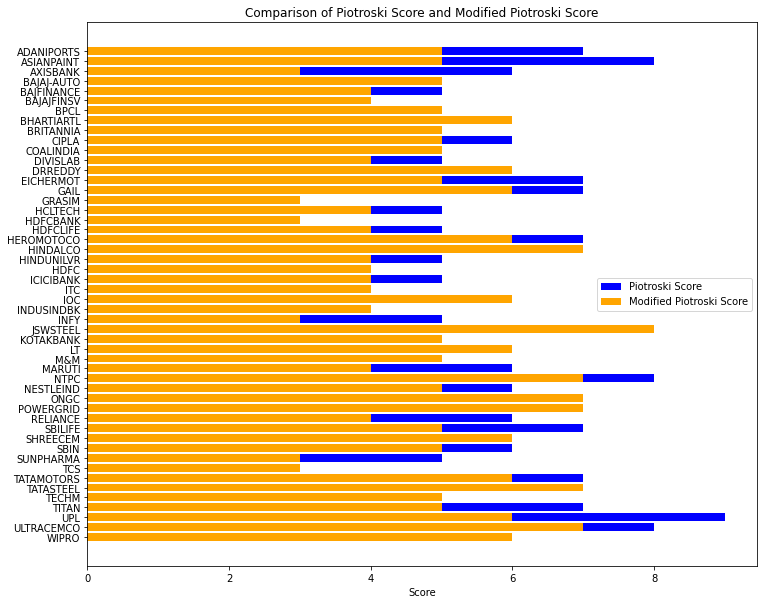

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski scores for each ticker
p_scores = [j[1] for j in nifty_p_score]
p_scores_modified = [j[1] for j in nifty_p_score_modified]

# Create a horizontal bar chart to compare Piotroski scores
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = range(len(nifty50_tickers))
ax.barh(y_pos, p_scores, align='center', color='blue', label='Piotroski Score')
ax.barh(y_pos, p_scores_modified, align='center', color='orange', label='Modified Piotroski Score')
ax.set_yticks(y_pos)
ax.set_yticklabels(nifty50_tickers)
ax.invert_yaxis()
ax.set_xlabel('Score')
ax.set_title('Comparison of Piotroski Score and Modified Piotroski Score')
ax.legend()
plt.show()


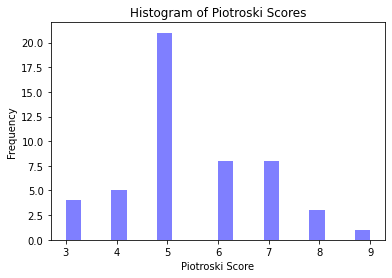

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski score for each ticker and append to list
p_scores = [j[1] for j in nifty_p_score]

# Plot histogram
plt.hist(p_scores, bins=20, color='blue', alpha=0.5)
plt.title('Histogram of Piotroski Scores')
plt.xlabel('Piotroski Score')
plt.ylabel('Frequency')
plt.show()


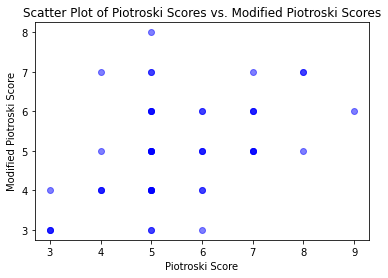

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski score and modified Piotroski score for each ticker and append to lists
p_scores = [j[1] for j in nifty_p_score]
p_scores_modified = [j[1] for j in nifty_p_score_modified]

# Plot scatter plot
plt.scatter(p_scores, p_scores_modified, color='blue', alpha=0.5)
plt.title('Scatter Plot of Piotroski Scores vs. Modified Piotroski Scores')
plt.xlabel('Piotroski Score')
plt.ylabel('Modified Piotroski Score')
plt.show()


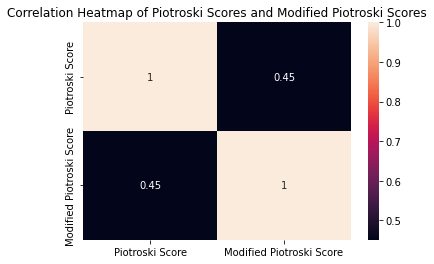

In [ ]:
import seaborn as sns

# Calculate Piotroski score and modified Piotroski score for each ticker and append to lists
p_scores = [j[1] for j in nifty_p_score]
p_scores_modified = [j[1] for j in nifty_p_score_modified]

# Create a dataframe with Piotroski scores and Modified Piotroski scores
df = pd.DataFrame({'Piotroski Score': p_scores, 'Modified Piotroski Score': p_scores_modified})

# Create heatmap
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heatmap of Piotroski Scores and Modified Piotroski Scores')
plt.show()


# Analysis of US Stocks for both original F-Score and modified F-Score

In [ ]:
# Create a list of tickers to calculate Piotroski score for
tickers = us30_tickers

# Print table header
print(f'{"Ticker":<10}   |{"Piotroski Score":<20}      |{"Modified Piotroski Score":<20}')
print('-' * 70)

# Loop through the tickers and calculate Piotroski score
us_p_score = list()
us_p_score_modified = list()
for ticker in tickers:
    p_score = calculate_piotroski_score(us_df, ticker, 19, country='us')
    p_score_modified = calculate_modified_piotroski_score(us_df, ticker, 19, input_country='us')
    us_p_score.append(p_score)
    us_p_score_modified.append(p_score_modified)
    print(f'{ticker:<10}   |   {p_score[1]:<20} |   {p_score_modified[1]:<20}')

Ticker       |Piotroski Score           |Modified Piotroski Score
----------------------------------------------------------------------


<ipython-input-7-cd9392d8a4fe>:13: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


XOM          |   8                    |   6                   
MSFT         |   5                    |   6                   
unh          |   6                    |   6                   
hd           |   6                    |   6                   
mcd          |   6                    |   6                   
amgn         |   6                    |   6                   
cat          |   6                    |   4                   
hon          |   6                    |   6                   
crm          |   7                    |   4                   
jnj          |   6                    |   8                   
aa           |   7                    |   4                   
pg           |   5                    |   7                   
wmt          |   6                    |   4                   
nke          |   5                    |   8                   
ko           |   6                    |   2                   
csco         |   5                    |   6            

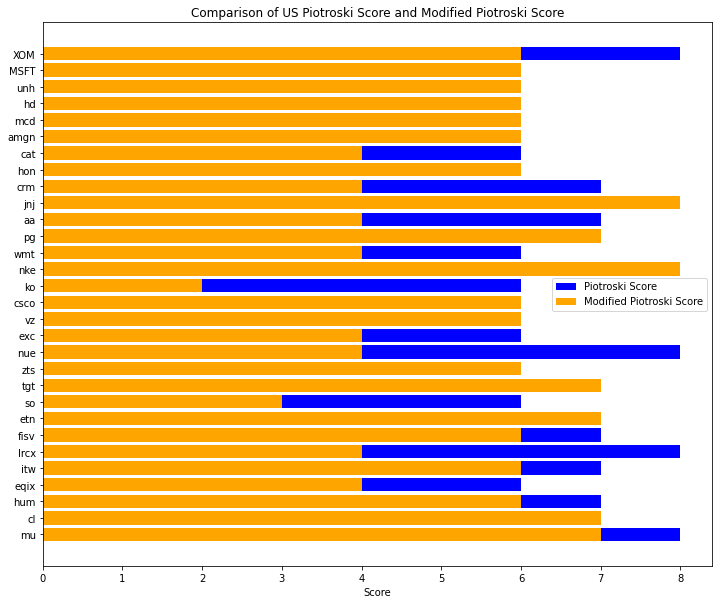

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski scores for each ticker
p_scores = [j[1] for j in us_p_score]
p_scores_modified = [j[1] for j in us_p_score_modified]

# Create a horizontal bar chart to compare Piotroski scores
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = range(len(us30_tickers))
ax.barh(y_pos, p_scores, align='center', color='blue', label='Piotroski Score')
ax.barh(y_pos, p_scores_modified, align='center', color='orange', label='Modified Piotroski Score')
ax.set_yticks(y_pos)
ax.set_yticklabels(us30_tickers)
ax.invert_yaxis()
ax.set_xlabel('Score')
ax.set_title('Comparison of US Piotroski Score and Modified Piotroski Score')
ax.legend()
plt.show()


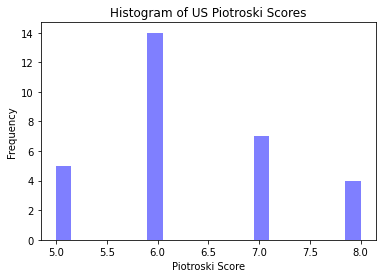

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski score for each ticker and append to list
p_scores = [j[1] for j in us_p_score]

# Plot histogram
plt.hist(p_scores, bins=20, color='blue', alpha=0.5)
plt.title('Histogram of US Piotroski Scores')
plt.xlabel('Piotroski Score')
plt.ylabel('Frequency')
plt.show()


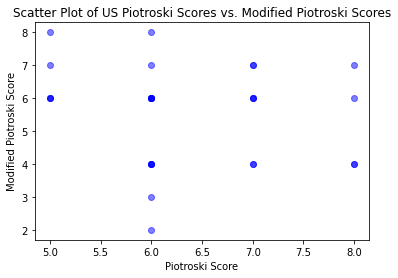

In [ ]:
import matplotlib.pyplot as plt

# Calculate Piotroski score and modified Piotroski score for each ticker and append to lists
p_scores = [j[1] for j in us_p_score]
p_scores_modified = [j[1] for j in us_p_score_modified]

# Plot scatter plot
plt.scatter(p_scores, p_scores_modified, color='blue', alpha=0.5)
plt.title('Scatter Plot of US Piotroski Scores vs. Modified Piotroski Scores')
plt.xlabel('Piotroski Score')
plt.ylabel('Modified Piotroski Score')
plt.show()


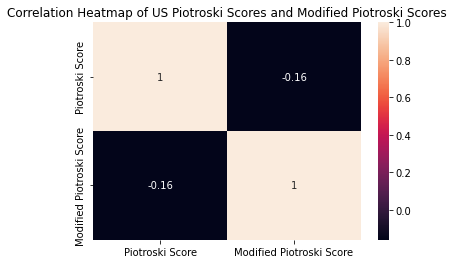

In [ ]:
import seaborn as sns

# Calculate Piotroski score and modified Piotroski score for each ticker and append to lists
p_scores = [j[1] for j in us_p_score]
p_scores_modified = [j[1] for j in us_p_score_modified]

# Create a dataframe with Piotroski scores and Modified Piotroski scores
df = pd.DataFrame({'Piotroski Score': p_scores, 'Modified Piotroski Score': p_scores_modified})

# Create heatmap
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heatmap of US Piotroski Scores and Modified Piotroski Scores')
plt.show()


The conclusion that the modified F-Score is better than the original F-Score is available in the report in greater detail. 

The above result also hold true for both emerging and non-emerging markets namely India and US. 